# Import Libraries

In [179]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Load the Data

In [180]:
# Load the data
df = pd.read_csv("cleaned_coursera_dataset.csv")

In [181]:
df.head(0)

,Course Title,Rating,Provider,Level,Reviews,Type,Duration / Weeks


In [182]:
df.drop('Course Title', axis=1, inplace=True)

In [183]:
df.rename(columns={'Duration / Weeks': 'duration_weeks', 'Type': 'course_type'}, inplace=True)

In [184]:
df.rename(columns={'type': 'course_type'}, inplace=True)

In [185]:
df.columns = df.columns.str.lower()

In [186]:
df

,rating,provider,level,reviews,course_type,duration_weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [187]:
df.dtypes

rating            float64
provider           object
level              object
reviews           float64
course_type        object
duration_weeks     object
dtype: object

In [188]:
# Create a histogram to show the count of each rating category to find outliers
fig_reviews_rating = px.histogram(df, x='rating',
                                  title='Count of Each Rating Category',
                                  labels={'Rating': 'Rating Category'})

fig_reviews_rating.show()

In [189]:

# decided to treat anything below 4 as an outlier

df = df[df['rating'] >= 4]


In [190]:
# Create a histogram to show the count of each rating category after removing outliers
fig_reviews_rating = px.histogram(df, x='rating',
                                  title='Count of Each Rating Category',
                                  labels={'Rating': 'Rating Category'})

fig_reviews_rating.show()

In [191]:
# Create a histogram to show the count of each rating category after removing outliers
fig_reviews_rating = px.histogram(df, x='reviews',
                                  title='Count of Each Rating Category',
                                  labels={'Rating': 'Rating Category'})

fig_reviews_rating.show()

In [192]:
df = df[(df['reviews'] > 50) & (df['reviews'] <= 100000)]


In [193]:
df.shape

(3309, 6)

# Preprocessing the Data

In [194]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['provider', 'level', 'course_type', 'duration_weeks'], dtype='object')

In [195]:
# Calculate the frequency of each 'Provider'
type_counts = df['provider'].value_counts()

# Filter 'provider' values that appear 2 or more times
df = df[df['provider'].isin(type_counts[type_counts >= 2].index)]

##  Encoding

### Split the rating to 5 categories by quantile

In [196]:
# creating the train data, a copy of the original
df_train = df.copy()

In [197]:
df_train.dtypes

rating            float64
provider           object
level              object
reviews           float64
course_type        object
duration_weeks     object
dtype: object

In [198]:
# Saving the categorical features in a list
categorical_features = df_train.select_dtypes(include=['object']).columns

In [199]:
encoder = LabelEncoder()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding on each categorical feature
for col in categorical_features:
    df_train[col] = label_encoder.fit_transform(df_train[col])

    # Get the mapping of labels
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # Print out the mappings and their labels
    print(f"Label Encoding Mapping {col}: {label_mapping}")

Label Encoding Mapping provider: {'Advancing Women in Tech': 0, 'Akamai Technologies, Inc.': 1, 'Amazon Web Services': 2, 'American Museum of Natural History': 3, 'American Psychological Association': 4, 'Aptly': 5, 'Arizona State University': 6, 'Arm': 7, 'Atlassian': 8, 'Autodesk': 9, 'Automatic Data Processing, Inc. (ADP)': 10, 'Automation Anywhere': 11, 'Berklee': 12, 'Board Infinity': 13, 'CVS Health': 14, 'California Institute of the Arts': 15, 'Caltech': 16, 'Case Western Reserve University': 17, 'CertNexus': 18, 'Cisco Learning and Certifications': 19, 'Cloudera': 20, 'Codio': 21, 'Columbia University': 22, 'Commonwealth Education Trust': 23, 'Copenhagen Business School': 24, 'Coursera': 25, 'Coursera Instructor Network': 26, 'Dartmouth College': 27, 'Databricks': 28, 'Deep Teaching Solutions': 29, 'DeepLearning.AI': 30, 'Digital Marketing Institute': 31, 'Duke University': 32, 'EC-Council': 33, 'EDHEC Business School': 34, 'EIT Digital': 35, 'ESSEC Business School': 36, 'Edge 

In [200]:
categorical_features

Index(['provider', 'level', 'course_type', 'duration_weeks'], dtype='object')

# Building and Training the model

In [201]:
wcss = []
for i in range(2, 20):  
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(df_train)
    wcss.append(kmeans.inertia_)

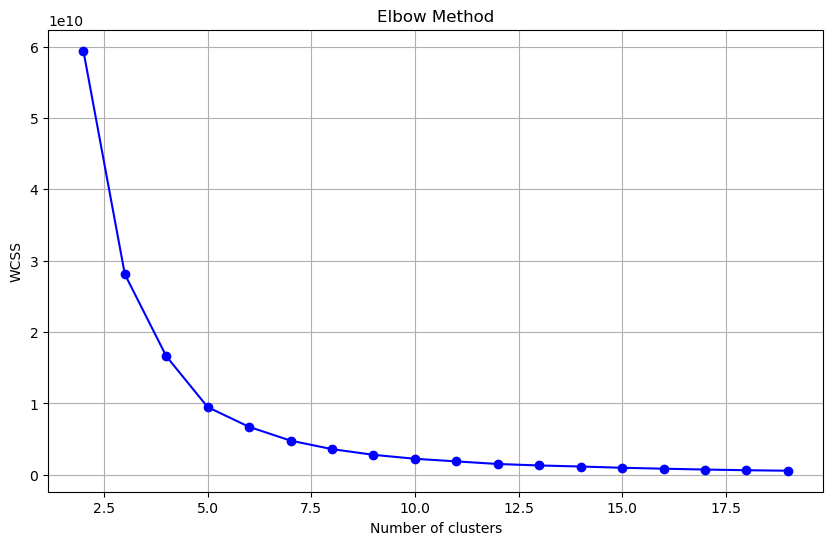

In [202]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [203]:
# Building the KMeans Model
optimal_clusters = 5

# Initialize and train the KMeans model
best_kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)


In [204]:
# predict
x_kmeans = best_kmeans.fit_predict(df_train)

# evaluate model

In [205]:
# Calculate the silhouette score, closer to 1 is better
silhouette_avg = silhouette_score(df_train, best_kmeans.labels_)

# Davies-Bouldin Index to evaluate clustering quality.
# Lower values indicate better separation between the clusters.
db_index = davies_bouldin_score(df_train, best_kmeans.labels_)

print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)


Silhouette Score: 0.7652169745728916
Davies-Bouldin Index: 0.4259456190923803


In [206]:
inertia = best_kmeans.inertia_
print("Inertia:", inertia)


Inertia: 9481392986.112364


In [207]:
df_train.columns

Index(['rating', 'provider', 'level', 'reviews', 'course_type',
       'duration_weeks'],
      dtype='object')

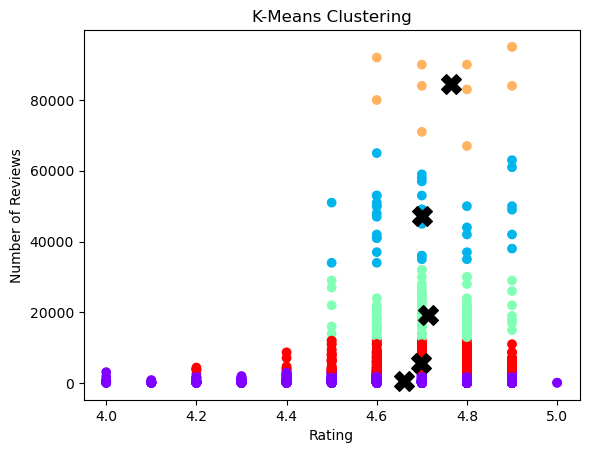

In [208]:
plt.scatter(df_train['rating'], df_train['reviews'], c=best_kmeans.labels_, cmap='rainbow')
plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 3], s=200, c='black', marker='X')
plt.title('K-Means Clustering')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()


# Predictions

In [209]:
df_train.columns

Index(['rating', 'provider', 'level', 'reviews', 'course_type',
       'duration_weeks'],
      dtype='object')

- level: {'Advanced': 0, 'Beginner': 1, 'Intermediate': 2, 'Mixed': 3}
- course_type: {'Course': 0, 'Professional Certificate': 1, 'Specialization': 2}
- duration_weeks: {'1 - 4': 0, '12 - 24': 1, '4 - 12': 2}

In [228]:
rating = 1
provider = 1
level = 1
reviews = 1
course_type = 1
duration = 1

new_data = [[rating, provider, level, reviews, course_type, duration]]  # Replace with your new data points
predictions = best_kmeans.predict(new_data)
print("Predicted clusters for new data:", predictions)


Predicted clusters for new data: [0]


# Clusters Distribution

In [211]:
df_train['Cluster'] = best_kmeans.labels_

In [212]:
cluster_0 = df[df_train['Cluster'] == 0]
cluster_1 = df[df_train['Cluster'] == 1]
cluster_2 = df[df_train['Cluster'] == 2]
cluster_3 = df[df_train['Cluster'] == 3]
cluster_4 = df[df_train['Cluster'] == 4]

In [213]:
cluster_0.shape

(2737, 6)

In [214]:
cluster_1.shape

(43, 6)

In [215]:
cluster_2.shape

(100, 6)

In [216]:
cluster_3.shape

(11, 6)

In [217]:
cluster_4.shape

(384, 6)

In [218]:
cluster_0['reviews'].mean()

730.1370113262697

In [219]:
cluster_4['reviews'].mean()

5771.614583333333

In [220]:
cluster_2['reviews'].mean()

19350.0

In [221]:
cluster_1['reviews'].mean()

47093.023255813954

In [222]:
cluster_3['reviews'].mean()

84636.36363636363

- Cluster 0 = very low
- Cluster 4 = low
- Cluster 2 = medium
- Cluster 1 = high
- Cluster 3 = very high

In [223]:
import joblib
joblib.dump(best_kmeans, 'kmens_model.joblib')
# joblib.dump(label_encoder, 'kmens_scaler.joblib')

['kmens_model.joblib']